# Classifying New York City Subway Stations
#### IBM Applied Data Science Capstone Project
##### By Ryan Albertson

<a id='ToC'></a>

## Table of Contents
* [Introduction](#Introduction)
* [Data](#Data)
    * [Load Venues With *Foursquare API*](#Foursquare_API)
* [Methodology](#Methology)
    * [Exploratory Data Analysis / Data Cleanup](#Exploratory_Data_Analysis)        
    * [Get Top 5 Venue Categories for Each Station](#Get_Top_5)
    * [Map Stations with Respect to Their Venue Category Ranks](#Map_Venue_Cat)
    * [K-Means Clustering](#K-Means_Clustering)
        * [Mapping the Clusters](#Map_Clusters)
        * [Cluster Analysis](#Cluster_Analysis)
* [Discussion](#Discussion)

<a id='Introduction'></a>

## Introduction
[Back to Table of Contents](#ToC)

Every day, roughly five million people ride the New York City subway system, which expands 665 miles across the five boroughs of the city. The system is currently comprised of 473 subway stations. I will be employing data from the Foursquare API to learn more about each of these stations. Specifically, I will pull venue data to understand which types of establishments are prominent around each station. From this information, the traffic of each station can be estimated. For example, a station with primarily university venues nearby will be busier on weekdays and not so much on the weekends. Whereas an area that has many entertainment venues will likely experience a traffic spike during the weekends. This information will be useful for city planners, because the classification of the subway stations will provide a good estimation of human traffic within a radius of each station. I will also use k-means clustering to see if the clusters have any correlation to the venue categories of each station.

<a id='Data'></a>

## Data
[Back to Table of Contents](#ToC)

Importing libraries

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import folium # library for creating maps
import json # reading a json file
from pandas.io.json import json_normalize # tranforming json file into a pandas data frame library
import seaborn as sns # library for data visualization
import matplotlib.pyplot as plt # library for basic plotting
from matplotlib import cm, colors # creating colormaps for map markers
from IPython.display import Image, display # viewing multiple images in one cell
from sklearn.preprocessing import MinMaxScaler # normalizing data
from sklearn.metrics import silhouette_score # choosing the best number of clusters for k-means
from sklearn.cluster import KMeans # calculating k-means clusters
from collections import Counter # count occurances of stations in each cluster

Load dataset containing subway stations and their coordinates

In [2]:
station_coordinates_df = pd.read_csv('NYC Subway Station Coordinates.csv')
station_coordinates_df.head()

Station Name                         Coordinates
0          Astor Pl  40.7300540002897,-73.9910699986196
1          Canal St   40.718803001077,-74.0001929992732
2           50th St  40.7617279996141,-73.9838489998662
3         Bergen St   40.6808621368295,-73.974999151168
4  Pennsylvania Ave  40.6647144514356,-73.8948859115406

Create a map showing the NYC subway stations and the venue search radius for each one

In [3]:
NYC_subway_map = folium.Map(width=1200, height=675, location=[40.7320, -73.9301], zoom_start=13)

for station, coordinates in zip(station_coordinates_df['Station Name'], station_coordinates_df['Coordinates']):
    
    latlong = [float(x) for x in coordinates.split(',')]
    label = folium.Popup(str(station))
    
    # Add a marker for each station.
    folium.Circle(latlong,
                  radius=20,
                  color='black',
                  fill=True
                 ).add_to(NYC_subway_map)
    
    # Add the venue search radius around each station.
    folium.Circle(latlong,        
                  radius=200,
                  color='gray',
                  fill=True,
                  fill_color='gray',
                  fill_opacity=0.4).add_to(NYC_subway_map)
NYC_subway_map

<a id='Foursquare_API'></a>

### Use *Foursquare API* to load in venues
[Back to Table of Contents](#ToC)

Define *Foursquare API* credentials and version

In [4]:
credentials = json.load(open('MY_CREDENTIALS.json'))
CLIENT_ID = credentials['MY_CLIENT_ID']
CLIENT_SECRET = credentials['MY_CLIENT_SECRET']
VERSION = credentials['MY_VERSION']
LIMIT = 50

Make get request to get the main categories of venues along with their category ID

In [5]:
categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(CLIENT_ID, 
                                                                                                             CLIENT_SECRET, 
                                                                                                             VERSION)
results = requests.get(categories_url).json()

categories_list = []

def print_categories(categories, level=0, max_level=0):
    """ Print out the main categories """
    if level > max_level: return
    out = ''
    out += '-' * level
    for category in categories:
        print(out + category['name'])
        print_categories(category['categories'], level+1, max_level)
        categories_list.append((category['name'], category['id'])) # Add category ID to list
        
print_categories(results['response']['categories'], 0, 0)

Arts & Entertainment
College & University
Event
Food
Nightlife Spot
Outdoors & Recreation
Professional & Other Places
Residence
Shop & Service
Travel & Transport


Make get request to get the count of nearby venues for each category, within a radius of each station

In [6]:
def get_venues_count(latlong, radius, categoryId):
    venues_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={}&radius={}&categoryId={}'.format(CLIENT_ID, 
                                                                                                                                        CLIENT_SECRET, 
                                                                                                                                        VERSION,
                                                                                                                                        latlong,
                                                                                                                                        radius,
                                                                                                                                        categoryId)   
    return requests.get(venues_url).json()['response']['totalResults']

Create a new data frame to store the venue categories

In [7]:
station_venues_df = station_coordinates_df.copy()
for category in categories_list:
    station_venues_df[category[0]] = 0

Request the count of venues for each station, then store the results in a CSV file

In [8]:
for idx, row in station_venues_df.iterrows():
    for category in categories_list:        
        station_venues_df.loc[idx, category[0]] = get_venues_count(station_venues_df.Coordinates.iloc[idx],
                                                                   radius=200,
                                                                   categoryId=category[1])
    station_venues_df.to_csv('station_venues.csv')

Read the CSV file into a data frame

In [9]:
station_venues_df = pd.read_csv('station_venues.csv', index_col=0)
station_venues_df.head()

Station Name                         Coordinates  Arts & Entertainment  \
0          Astor Pl  40.7300540002897,-73.9910699986196                    23   
1          Canal St   40.718803001077,-74.0001929992732                    15   
2           50th St  40.7617279996141,-73.9838489998662                    44   
3         Bergen St   40.6808621368295,-73.974999151168                     3   
4  Pennsylvania Ave  40.6647144514356,-73.8948859115406                     1   

   College & University  Event  Food  Nightlife Spot  Outdoors & Recreation  \
0                    44      1    24              13                     27   
1                     6      0    25               6                     24   
2                     3      3    24              25                     25   
3                     1      0    22              13                     13   
4                     1      0     6               0                      0   

   Professional & Other Places  Residence  Shop & Service  Travel & Transport  
0                           88          5             103                  24  
1                          125         10             156                  14  
2                          107          7              85                  31  
3                           25          3              45                   6  
4                            5          0               4                   3

<a id='Exploratory_Data_Analysis'></a>

## Exploratory Analysis and Data Cleanup
[Back to Table of Contents](#ToC)

Find which stations have the most venues around them

In [10]:
station_venues_sum_df = station_venues_df.copy()
station_venues_sum_df['Sum'] = station_venues_sum_df.sum(axis=1)
for idx, row in enumerate(station_venues_sum_df.nlargest(20, 'Sum').iterrows()):
    print("{}. {}:\tNumber of Venues =    {}".format(idx+1, row[1][0], row[1][11]).expandtabs(39))

1. 34th St - Penn Station:             Number of Venues =    31
2. W 4th St - Washington Sq (Upper):   Number of Venues =    56
3. Grand Central - 42nd St:            Number of Venues =    68
4. Grand Central - 42nd St:            Number of Venues =    60
5. 28th St:                            Number of Venues =    26
6. Roosevelt Island - Main St:         Number of Venues =    33
7. Wall St:                            Number of Venues =    18
8. Prince St:                          Number of Venues =    18
9. Broadway - Lafayette St:            Number of Venues =    17
10. Broad St:                          Number of Venues =    14
11. Hoyt - Schermerhorn Sts:           Number of Venues =    30
12. Wall St:                           Number of Venues =    16
13. Pelham Bay Park:                   Number of Venues =    17
14. Times Sq - 42nd St:                Number of Venues =    24
15. Fulton St:                         Number of Venues =    18
16. World Trade Center:                N

Create a boxplot and swarmplot to show the count of each venue category

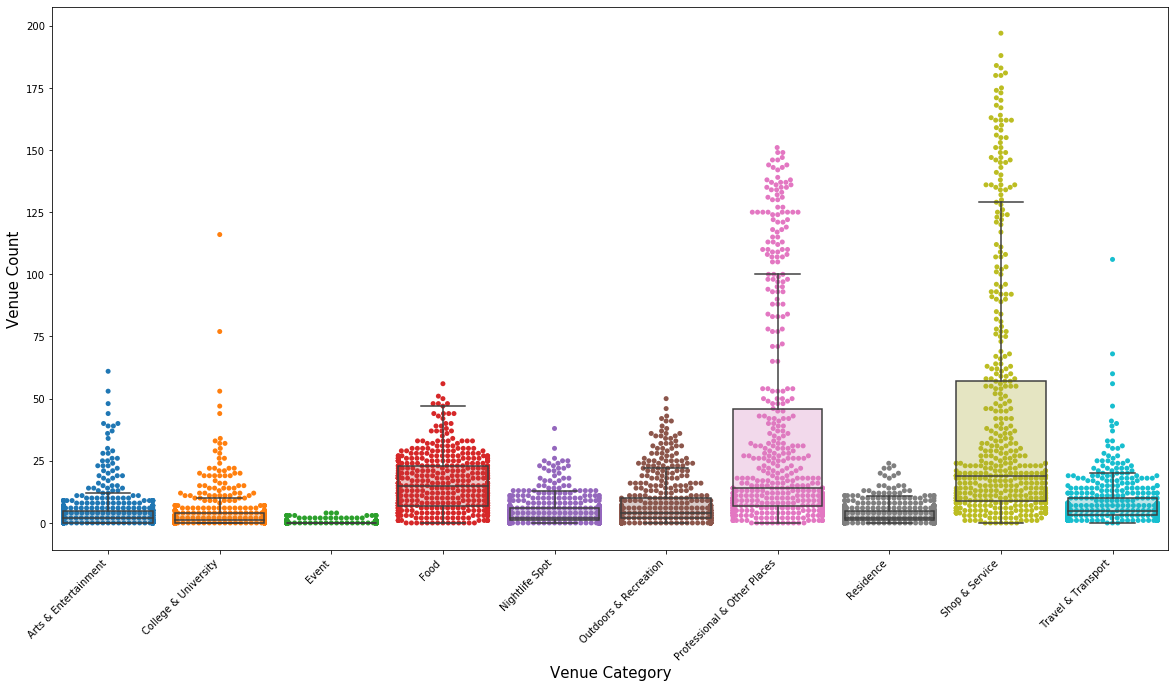

In [11]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=station_venues_df, showfliers=False)
sns.swarmplot

ax = sns.swarmplot(data=station_venues_df, zorder=.5)
ax.set_ylabel('Venue Count', fontsize=15)
ax.set_xlabel('Venue Category', fontsize=15)
ax.tick_params(labelsize=10)
plt.xticks(rotation=45, ha='right')
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))

plt.show()

Drop the *Event* category from the data frame and the category list, because it has very little data

In [12]:
station_venues_df.drop('Event', 1, inplace=True)
categories_list = [x for x in categories_list if x[0] != 'Event']

Function that sorts the venues of each station (row) in descending order

In [13]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

<a id='Get_Top_5'></a>

### Get Top 5 Venue Categories for Each Station
[Back to Table of Contents](#ToC)

Create new data frame that has the top 5 categories by count for each station

In [14]:
station_venues_sorted_df = station_coordinates_df.copy()

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

columns = []
for idx in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(idx+1, indicators[idx]))
    except:
        columns.append('{}th Most Common Venue'.format(idx+1))
        
for column in columns:
    station_venues_sorted_df[column] = 0
    
station_venues_sorted_df.head()

Station Name                         Coordinates  \
0          Astor Pl  40.7300540002897,-73.9910699986196   
1          Canal St   40.718803001077,-74.0001929992732   
2           50th St  40.7617279996141,-73.9838489998662   
3         Bergen St   40.6808621368295,-73.974999151168   
4  Pennsylvania Ave  40.6647144514356,-73.8948859115406   

   1st Most Common Venue  2nd Most Common Venue  3rd Most Common Venue  \
0                      0                      0                      0   
1                      0                      0                      0   
2                      0                      0                      0   
3                      0                      0                      0   
4                      0                      0                      0   

   4th Most Common Venue  5th Most Common Venue  
0                      0                      0  
1                      0                      0  
2                      0                      0  
3                      0                      0  
4                      0                      0

In [15]:
for idx in np.arange(station_venues_df.shape[0]):
    station_venues_sorted_df.iloc[idx, 2:] = return_most_common_venues(station_venues_df.iloc[idx, :], num_top_venues)

station_venues_sorted_df.head()

Station Name                         Coordinates  \
0          Astor Pl  40.7300540002897,-73.9910699986196   
1          Canal St   40.718803001077,-74.0001929992732   
2           50th St  40.7617279996141,-73.9838489998662   
3         Bergen St   40.6808621368295,-73.974999151168   
4  Pennsylvania Ave  40.6647144514356,-73.8948859115406   

         1st Most Common Venue        2nd Most Common Venue  \
0               Shop & Service  Professional & Other Places   
1               Shop & Service  Professional & Other Places   
2  Professional & Other Places               Shop & Service   
3               Shop & Service  Professional & Other Places   
4                         Food  Professional & Other Places   

  3rd Most Common Venue  4th Most Common Venue  5th Most Common Venue  
0  College & University  Outdoors & Recreation     Travel & Transport  
1                  Food  Outdoors & Recreation   Arts & Entertainment  
2  Arts & Entertainment     Travel & Transport  Outdoors & Recreation  
3                  Food  Outdoors & Recreation         Nightlife Spot  
4        Shop & Service     Travel & Transport   College & University

<a id='Map_Venue_Cat'></a>

### Map the Stations With Respect to Their Venue Category Ranks
[Back to Table of Contents](#ToC)

Function that creates a map for the given rank of a venue category count

In [16]:
def create_venue_cat_map(venue_rank_str):

    venue_cat_map = folium.Map(width=1200, height=675,location=[40.7320, -73.9301], zoom_start=11)
    
    # create color map then assign colors to venue category names
    cmap = cm.get_cmap('hsv')
    color_indices = np.linspace(0, 1, 11)
    rgb_colors = [colors.to_hex(list(rgba)) for rgba in [cmap(idx) for idx in color_indices]]
    color_dict = {k:v for (k,v) in zip(station_venues_df.columns[2:], rgb_colors)}

    for coordinates, venue_cat in zip(station_venues_sorted_df['Coordinates'], station_venues_sorted_df[venue_rank_str]):

        latlong = [float(x) for x in coordinates.split(',')]
        label = folium.Popup(str(venue_cat))

        # Add a marker for each station.
        folium.CircleMarker(latlong,
                            radius=5,
                            popup=label,
                            color=color_dict[venue_cat],
                            fill=True,
                            fill_color=color_dict[venue_cat],
                            fill_opacity=0.6).add_to(venue_cat_map)
        
    return venue_cat_map

Loop to create a map for each tier of venue category rank

In [17]:
map_names = ["venue_rank_{}_map".format(x) for x in range(1, 6)]
map_names_dict = {}
for map_name, column in zip(map_names, station_venues_sorted_df.columns[2:]):
    map_names_dict[map_name] = create_venue_cat_map(column)       

Display every created map

'1st Most Common Categories'

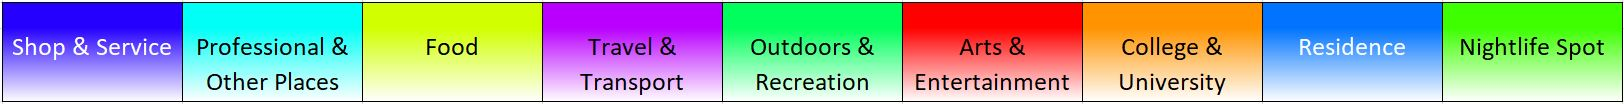

'2nd Most Common Categories'

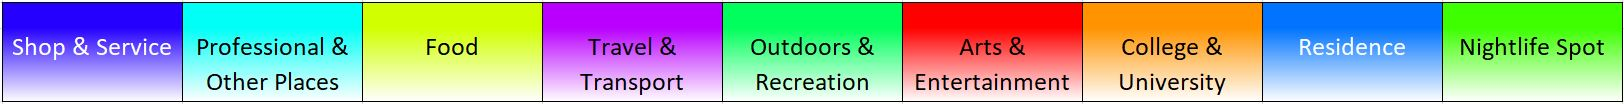

'3rd Most Common Categories'

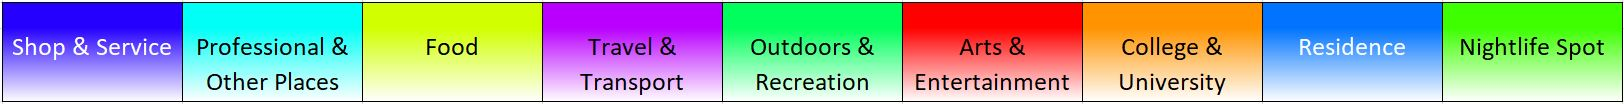

'4th Most Common Categories'

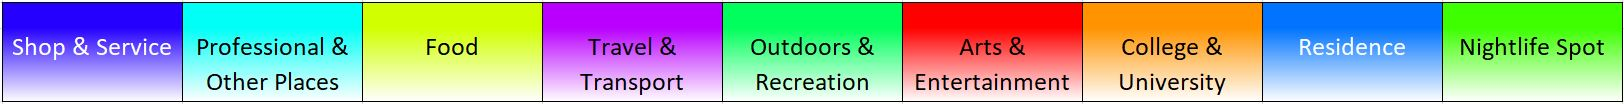

'5th Most Common Categories'

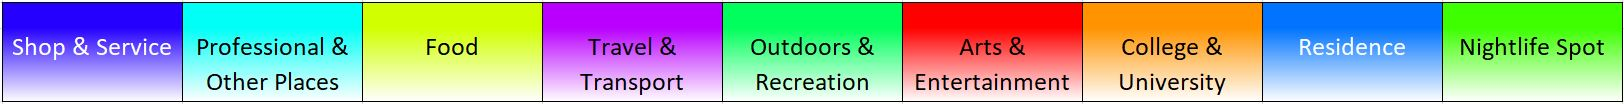

In [18]:
legend = Image(filename='venue_cat_legend.JPG', width=800) # Legend made in Excel and saved as JPG

display('1st Most Common Categories')
display(legend)
display(map_names_dict['venue_rank_1_map'])
display('2nd Most Common Categories')
display(legend)
display(map_names_dict['venue_rank_2_map'])
display('3rd Most Common Categories')
display(legend)
display(map_names_dict['venue_rank_3_map'])
display('4th Most Common Categories')
display(legend)
display(map_names_dict['venue_rank_4_map'])
display('5th Most Common Categories')
display(legend)
display(map_names_dict['venue_rank_5_map'])

<a id='K-Means_Clustering'></a>

## K-Means Clustering
[Back to Table of Contents](#ToC)

Scale the data to values between 0 and 1

In [19]:
X = station_venues_df.values[:,2:]
cluster_dataset = MinMaxScaler().fit_transform(X)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [20]:
cluster_df = pd.DataFrame(cluster_dataset)
cluster_df.columns = [category[0] for category in categories_list]
cluster_df.head()

Arts & Entertainment  College & University      Food  Nightlife Spot  \
0              0.377049              0.379310  0.428571        0.342105   
1              0.245902              0.051724  0.446429        0.157895   
2              0.721311              0.025862  0.428571        0.657895   
3              0.049180              0.008621  0.392857        0.342105   
4              0.016393              0.008621  0.107143        0.000000   

   Outdoors & Recreation  Professional & Other Places  Residence  \
0                   0.54                     0.582781   0.208333   
1                   0.48                     0.827815   0.416667   
2                   0.50                     0.708609   0.291667   
3                   0.26                     0.165563   0.125000   
4                   0.00                     0.033113   0.000000   

   Shop & Service  Travel & Transport  
0        0.522843            0.226415  
1        0.791878            0.132075  
2        0.431472            0.292453  
3        0.228426            0.056604  
4        0.020305            0.028302

Visualize the scaled data

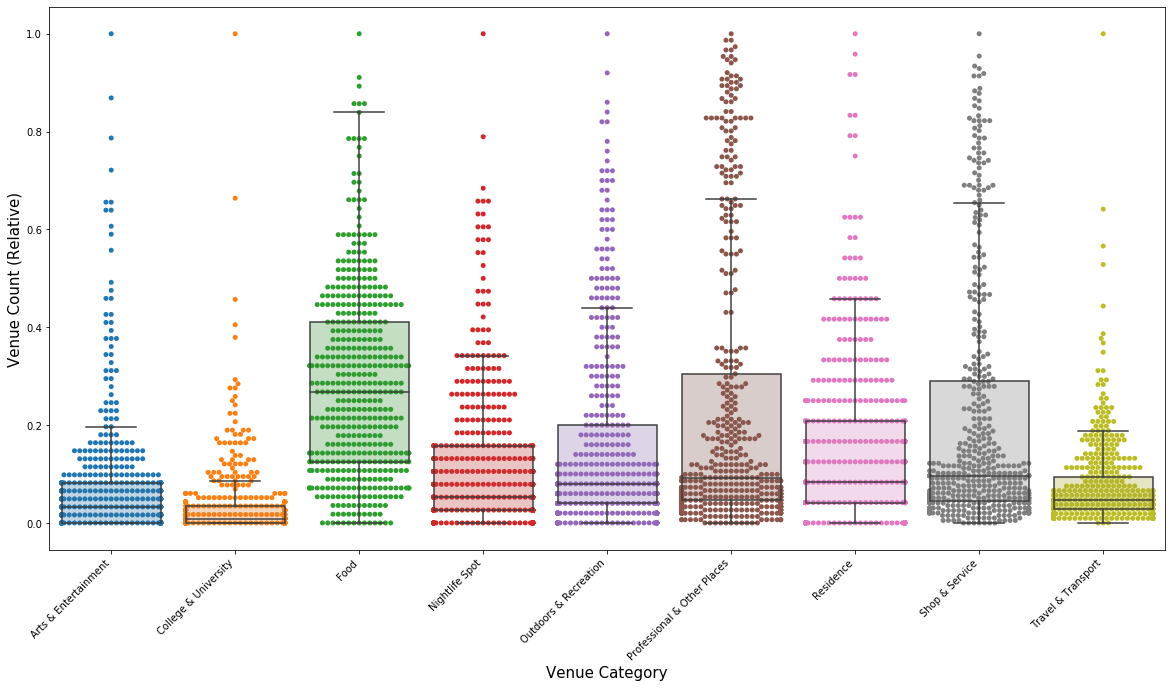

In [21]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=cluster_df, showfliers=False)
sns.swarmplot

ax = sns.swarmplot(data=cluster_df, zorder=.5)
ax.set_ylabel('Venue Count (Relative)', fontsize=15)
ax.set_xlabel('Venue Category', fontsize=15)
ax.tick_params(labelsize=10)
plt.xticks(rotation=45, ha='right')
# Make the boxplot fill colors transparent
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))

plt.show()

Calculate the optimal number of clusters using *The Silhouette Method*

In [22]:
sil = []
K_sil = range(2,20)
for k in K_sil:
    kmeans = KMeans(n_clusters = k).fit(cluster_df)
    labels = kmeans.labels_
    sil.append(silhouette_score(cluster_df, labels, metric = 'euclidean'))

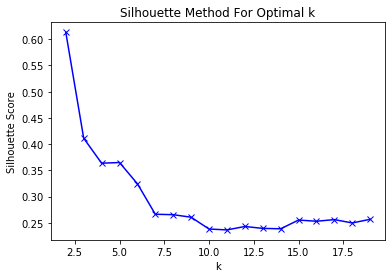

In [23]:
plt.plot(K_sil, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')
plt.show()

The optimal number of clusters appears to be 6

In [24]:
kclusters = 6

kmeans = KMeans(init='k-means++', n_clusters=kclusters, random_state=0).fit(cluster_df)

# print how many stations are in each cluster
print(Counter(kmeans.labels_))

Counter({2: 247, 5: 87, 4: 49, 1: 38, 0: 35, 3: 17})


Add the corresponding cluster to each station in the data frame

In [25]:
try:
    station_venues_sorted_df.drop('Cluster Label', axis=1)
except:
    station_venues_sorted_df.insert(0, 'Cluster Label', kmeans.labels_)
    
station_venues_sorted_df.head()

Cluster Label      Station Name                         Coordinates  \
0              3          Astor Pl  40.7300540002897,-73.9910699986196   
1              4          Canal St   40.718803001077,-74.0001929992732   
2              3           50th St  40.7617279996141,-73.9838489998662   
3              5         Bergen St   40.6808621368295,-73.974999151168   
4              2  Pennsylvania Ave  40.6647144514356,-73.8948859115406   

         1st Most Common Venue        2nd Most Common Venue  \
0               Shop & Service  Professional & Other Places   
1               Shop & Service  Professional & Other Places   
2  Professional & Other Places               Shop & Service   
3               Shop & Service  Professional & Other Places   
4                         Food  Professional & Other Places   

  3rd Most Common Venue  4th Most Common Venue  5th Most Common Venue  
0  College & University  Outdoors & Recreation     Travel & Transport  
1                  Food  Outdoors & Recreation   Arts & Entertainment  
2  Arts & Entertainment     Travel & Transport  Outdoors & Recreation  
3                  Food  Outdoors & Recreation         Nightlife Spot  
4        Shop & Service     Travel & Transport   College & University

<a id='Map_Clusters'></a>

### Mapping the Clusters
[Back to Table of Contents](#ToC)

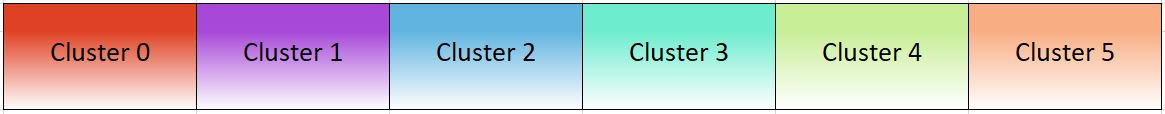

In [26]:
cluster_map = folium.Map(width=1200, height=675, location=[40.7320, -73.9301], zoom_start=11)
legend = Image(filename='cluster_map_legend.JPG', width=650) # legend made in Excel and saved as JPG

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for cluster, station, coordinates in zip(station_venues_sorted_df['Cluster Label'],
                                         station_venues_sorted_df['Station Name'],
                                         station_venues_sorted_df['Coordinates']):
                         
    label = folium.Popup(str(station) + ' - Cluster ' + str(cluster), parse_html=True)
    latlong = [float(x) for x in coordinates.split(',')]
                         
    folium.CircleMarker(
        latlong,
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(cluster_map)
       

display(legend)
display(cluster_map)

<a id='Cluster_Analysis'></a>

### Cluster Analysis
[Back to Table of Contents](#ToC)

Analyze each cluster by showing the count of which venue category is the 1st, 2nd, 3rd most common

In [27]:
# 1st Most Common Venue, 2nd Most Common Venue, 3rd Most Common Venue
required_column_indices = [3, 4, 5]
required_columns = [list(station_venues_sorted_df.columns.values)[idx] for idx in required_column_indices]

In [28]:
cluster_names = ["cluster_{}".format(x) for x in range(6)]
cluster_names_dict = {}

for idx in range(6):
    cluster_names_dict[cluster_names[idx]] = station_venues_sorted_df.loc[station_venues_sorted_df['Cluster Label'] == idx, station_venues_sorted_df.columns[1:12]]
    
    for column in required_columns:
        print("\t\tCLUSTER {}".format(idx))
        print(cluster_names_dict[cluster_names[idx]][column].value_counts(ascending = False))
        print("-" * 41)
    
    print("\n\n\n\n")     
    

		CLUSTER 0
Shop & Service                 13
Professional & Other Places     9
Food                            9
Residence                       2
College & University            1
Outdoors & Recreation           1
Name: 1st Most Common Venue, dtype: int64
-----------------------------------------
		CLUSTER 0
Food                           12
Shop & Service                  9
Professional & Other Places     7
Residence                       6
Outdoors & Recreation           1
Name: 2nd Most Common Venue, dtype: int64
-----------------------------------------
		CLUSTER 0
Residence                      11
Professional & Other Places     9
Shop & Service                  8
Outdoors & Recreation           5
Food                            1
Nightlife Spot                  1
Name: 3rd Most Common Venue, dtype: int64
-----------------------------------------





		CLUSTER 1
Professional & Other Places    24
Shop & Service                 14
Name: 1st Most Common Venue, dtype: int64
-------

<a id='Discussion'></a>

## Discussion
[Back to Table of Contents](#ToC)

After relating the categories of venues with each of the subway stations, some meaningful inferences can be made. Specifically with the first most common venue categories, city planners can use this data for whichever projects may relate to human traffic in New York City. By associating the categories with times of congestion, this data can be useful for predictions. Another step can be taken to retrieve the sub-categories of venues and join them to each station accordingly. This would reduce the number of data points for each variable of the data, but in return provide more specific information. The biggest challenge will be to establish the magnitudes of the first most common through fifth most common venue categories. How significant is the first most common, then how much less significant is the second most common, etc.

Moving on to the discussion about the k-means clustering. Using Euclidean distance as the classifier of the k-means algorithm and a k-value of six, three clusters of interest were discovered. Looking at the first and second most common venue categories for all three, each had almost exclusively Shop & Service and Professional & Other venues. Seeing as these three clusters are also centered geographically around Lower Manhattan, they could be a good candidate for further analysis. 
